In [2]:
# Install scikeras first.
!pip install scikeras

# Explicitly install scikit-learn 1.5.2.
!pip install scikit-learn==1.5.2 --force-reinstall --no-deps

# Verify the scikit-learn version immediately after installation
import sklearn
print("Scikit-learn version after explicit install:", sklearn.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 80.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Scikit-learn version after explicit install: 1.5.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# NYC Taxi Trip Duration - Deep Learning Project

# Part 1: Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor, KerasClassifier
from keras.callbacks import EarlyStopping
import datetime

In [5]:
# Part 2: Load & Inspect Dataset
url = "/content/drive/MyDrive/Sample/NYC.csv"
df = pd.read_csv(url)
print(df.head(10))
# print(df.info())
# print(df.describe())


          id  vendor_id  pickup_datetime dropoff_datetime  passenger_count  \
0  id2875421          2  14/3/2016 17:24  14/3/2016 17:32                1   
1  id2377394          1   12/6/2016 0:43   12/6/2016 0:54                1   
2  id3858529          2  19/1/2016 11:35  19/1/2016 12:10                1   
3  id3504673          2   6/4/2016 19:32   6/4/2016 19:39                1   
4  id2181028          2  26/3/2016 13:30  26/3/2016 13:38                1   
5  id0801584          2  30/1/2016 22:01  30/1/2016 22:09                6   
6  id1813257          1  17/6/2016 22:34  17/6/2016 22:40                4   
7  id1324603          2   21/5/2016 7:54   21/5/2016 8:20                1   
8  id1301050          1  27/5/2016 23:12  27/5/2016 23:16                1   
9  id0012891          2  10/3/2016 21:45  10/3/2016 22:05                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         

In [6]:
# Part 3: Data Preprocessing
df.dropna(inplace=True)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
df['distance'] = np.sqrt(
    (df['dropoff_longitude'] - df['pickup_longitude'])**2 +
    (df['dropoff_latitude'] - df['pickup_latitude'])**2
)
df = df[(df['trip_duration'] > 60) & (df['trip_duration'] < 7200)]
df['trip_class'] = pd.qcut(df['trip_duration'], q=3, labels=[0, 1, 2])

features = ['passenger_count', 'pickup_hour', 'pickup_day', 'distance']
X = df[features]
y_reg = df['trip_duration']
y_clf = df['trip_class'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/tmp/ipython-input-812504848.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
/tmp/ipython-input-812504848.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_class'] = pd.qcut(df['trip_duration'], q=3, labels=[0, 1, 2])


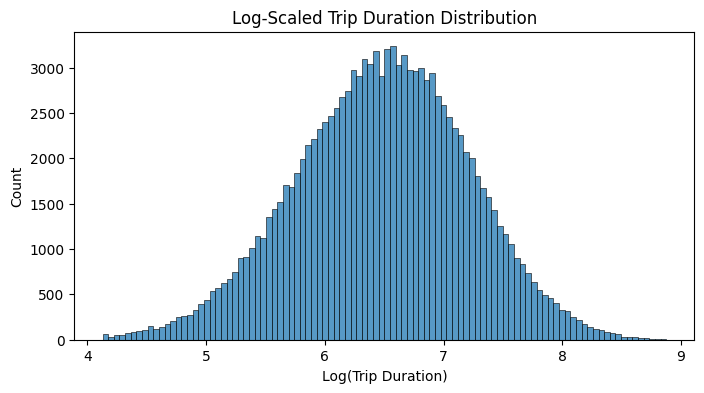

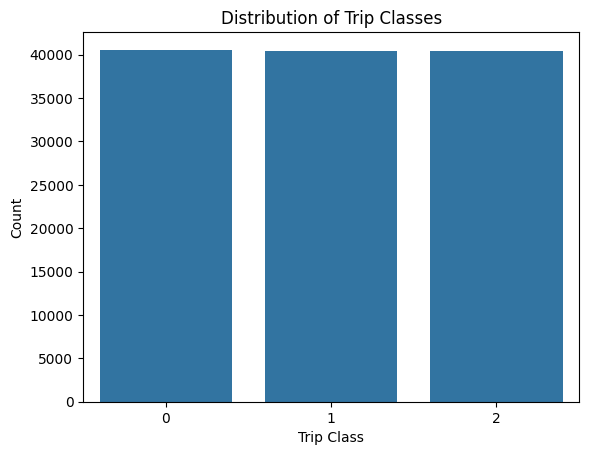

In [7]:
# EDA (Exploratory Data Analysis)
# Log-transformed histogram
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(df['trip_duration']), bins=100, kde=False)
plt.title('Log-Scaled Trip Duration Distribution')
plt.xlabel('Log(Trip Duration)')
plt.ylabel('Count')
plt.show()

sns.countplot(x='trip_class', data=df)
plt.title('Distribution of Trip Classes')
plt.xlabel('Trip Class')
plt.ylabel('Count')
plt.show()

In [ ]:
# Part 4: Baseline Models
reg_base = LinearRegression()
reg_base.fit(X_scaled, y_reg)
y_pred_base_reg = reg_base.predict(X_scaled)
print("Baseline Regression R^2:", r2_score(y_reg, y_pred_base_reg))

clf_base = LogisticRegression(max_iter=200)
clf_base.fit(X_scaled, y_clf)
y_pred_base_clf = clf_base.predict(X_scaled)
print("Baseline Classification Accuracy:", clf_base.score(X_scaled, y_clf))

Baseline Regression R^2: 0.5842612131997309
Baseline Classification Accuracy: 0.6767254159117114


In [ ]:
# Part 5: Deep Learning Models (UPDATED again for robustness)
def build_reg_model(units=64, dropout_rate=0.3, optimizer='adam', input_shape=None, **kwargs):
    model = Sequential([
        Dense(units, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(units//2, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model

def build_clf_model(units=64, dropout_rate=0.3, optimizer='adam', input_shape=None, **kwargs):
    model = Sequential([
        Dense(units, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(units//2, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3036/3036 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 510844.4062 - val_loss: 176978.3750
Epoch 2/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 181731.4062 - val_loss: 171461.9375
Epoch 3/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 177480.1875 - val_loss: 159137.9844
Epoch 4/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 163709.1719 - val_loss: 155368.6875
Epoch 5/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 160586.2969 - val_loss: 154580.7031
Epoch 6/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 164480.8594 - val_loss: 154671.7500
Epoch 7/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 162957.2344 - val_loss: 154240.7656
Epoch 8/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 167928.9062 - val_loss: 154057.0156
Epoch 9/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 164034.6250 - val_loss: 154759.1406
Epoch 10/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 162122.1094 - val_loss: 154358.1875
Epoch 11/50
3036/3036 ━━

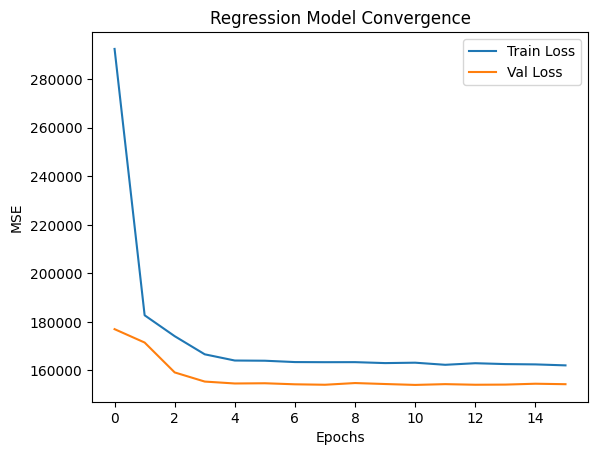

In [ ]:
# Part 6: Training & Convergence
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

reg_model = build_reg_model(input_shape=(X_scaled.shape[1],))
history_reg = reg_model.fit(
    X_train_r, y_train_r,
    validation_data=(X_val_r, y_val_r),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Val Loss')
plt.title('Regression Model Convergence')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

Epoch 1/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - accuracy: 0.6392 - loss: 0.7730 - val_accuracy: 0.7050 - val_loss: 0.6686
Epoch 2/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6981 - loss: 0.6770 - val_accuracy: 0.7097 - val_loss: 0.6587
Epoch 3/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7009 - loss: 0.6728 - val_accuracy: 0.7155 - val_loss: 0.6511
Epoch 4/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7031 - loss: 0.6684 - val_accuracy: 0.7136 - val_loss: 0.6544
Epoch 5/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7075 - loss: 0.6581 - val_accuracy: 0.7172 - val_loss: 0.6473
Epoch 6/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7093 - loss: 0.6571 - val_accuracy: 0.7159 - val_loss: 0.6439
Epoch 7/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7081 - loss: 0.6587 - val_accuracy: 0.7090 - val_loss: 0.6476
Epoch 8/50
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7084 - loss: 0

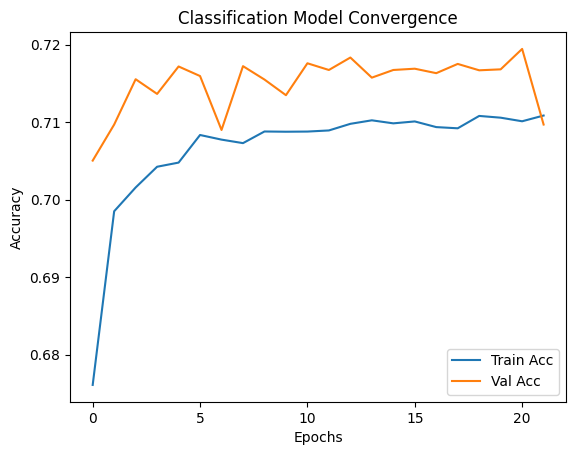

In [ ]:
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=42)

clf_model = build_clf_model(input_shape=(X_scaled.shape[1],))
history_clf = clf_model.fit(
    X_train_c, y_train_c,
    validation_data=(X_val_c, y_val_c),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

plt.plot(history_clf.history['accuracy'], label='Train Acc')
plt.plot(history_clf.history['val_accuracy'], label='Val Acc')
plt.title('Classification Model Convergence')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Part 7: Hyperparameter Tuning & Cross-Validation
print("Running Grid Search for Regression Model...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Pass the input_shape as a tuple when initializing the wrapper.
reg_wrapper = KerasRegressor(model=build_reg_model, verbose=0, input_shape=(X_scaled.shape[1],))

reg_param_grid = {
    'model__units': [32, 64],
    'model__dropout_rate': [0.2, 0.3],
    'optimizer': ['adam'],
    'epochs': [20],
    'batch_size': [32, 64]
}

reg_grid = GridSearchCV(estimator=reg_wrapper, param_grid=reg_param_grid, cv=kfold, scoring='neg_mean_squared_error')
reg_grid_result = reg_grid.fit(X_scaled, y_reg)
print("Best Params (Reg):", reg_grid_result.best_params_)
print("MSE (CV):", -reg_grid_result.best_score_)

print("\nRunning Grid Search for Classification Model...")
# Pass the input_shape as a tuple when initializing the wrapper.
clf_wrapper = KerasClassifier(model=build_clf_model, verbose=0, input_shape=(X_scaled.shape[1],))

clf_param_grid = {
    'model__units': [32, 64],
    'model__dropout_rate': [0.2, 0.3],
    'optimizer': ['adam'],
    'epochs': [20],
    'batch_size': [32, 64]
}
clf_grid = GridSearchCV(estimator=clf_wrapper, param_grid=clf_param_grid, cv=kfold, scoring='accuracy')
clf_grid_result = clf_grid.fit(X_scaled, y_clf)
print("Best Params (Clf):", clf_grid_result.best_params_)
print("Accuracy (CV):", clf_grid_result.best_score_)

Running Grid Search for Regression Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Best Params (Reg): {'batch_size': 64, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__units': 64, 'optimizer': 'adam'}
MSE (CV): 135248.8878582882

Running Grid Search for Classification Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Best Params (Clf): {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__units': 64, 'optimizer': 'adam'}
Accuracy (CV): 0.7146598583429419


Regression CV Mean MSE: 150945.79864976509
Regression CV Std MSE: 9321.669882907758
Classification CV Mean Accuracy: 0.7128387003788503
Classification CV Std Accuracy: 0.003374273129528388
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
DL Regression MSE: 155754.26887250808
DL Regression MAE: 262.0721220566598
DL Regression R^2: 0.6338164806365967
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
DL Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.81      0.77     40567
           1       0.60      0.58      0.59     40400
           2       0.81      0.76      0.78     40453

    accuracy                           0.71    121420
   macro avg       0.72      0.71      0.71    121420
weighted avg       0.72      0.71      0.71    121420



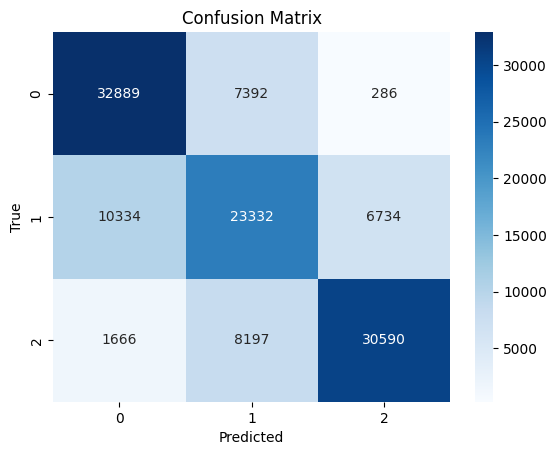

In [ ]:
# Part 8: Evaluation Metrics

# Report mean and std from cross-validation
reg_mse_scores = -reg_grid_result.cv_results_['mean_test_score']
reg_std_scores = reg_grid_result.cv_results_['std_test_score']
print("Regression CV Mean MSE:", np.mean(reg_mse_scores))
print("Regression CV Std MSE:", np.mean(reg_std_scores))

clf_acc_scores = clf_grid_result.cv_results_['mean_test_score']
clf_std_scores = clf_grid_result.cv_results_['std_test_score']
print("Classification CV Mean Accuracy:", np.mean(clf_acc_scores))
print("Classification CV Std Accuracy:", np.mean(clf_std_scores))

y_pred_dl_reg = reg_model.predict(X_scaled)
print("DL Regression MSE:", mean_squared_error(y_reg, y_pred_dl_reg))
print("DL Regression MAE:", mean_absolute_error(y_reg, y_pred_dl_reg))
print("DL Regression R^2:", r2_score(y_reg, y_pred_dl_reg))

y_pred_dl_clf = np.argmax(clf_model.predict(X_scaled), axis=1)
print("DL Classification Report:\n", classification_report(y_clf, y_pred_dl_clf))
sns.heatmap(confusion_matrix(y_clf, y_pred_dl_clf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
